**SIMCLR MODEL COMPLETE PIPELINE**

c:\Users\Parul\miniconda3\envs\vissl_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Parul\miniconda3\envs\vissl_env\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\Parul\miniconda3\envs\vissl_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Parul\miniconda3\envs\vissl_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'wei

Epoch 1 - Loss: 2.1557


Epoch 2/20: 100%|██████████| 125/125 [00:30<00:00,  4.08it/s]


Epoch 2 - Loss: 1.9000


Epoch 3/20: 100%|██████████| 125/125 [00:29<00:00,  4.30it/s]


Epoch 3 - Loss: 1.6946


Epoch 4/20: 100%|██████████| 125/125 [00:28<00:00,  4.46it/s]


Epoch 4 - Loss: 1.6975


Epoch 5/20: 100%|██████████| 125/125 [00:28<00:00,  4.42it/s]


Epoch 5 - Loss: 1.7149


Epoch 6/20: 100%|██████████| 125/125 [00:28<00:00,  4.46it/s]


Epoch 6 - Loss: 1.6273


Epoch 7/20: 100%|██████████| 125/125 [00:35<00:00,  3.55it/s]


Epoch 7 - Loss: 1.6493


Epoch 8/20: 100%|██████████| 125/125 [00:43<00:00,  2.84it/s]


Epoch 8 - Loss: 1.6306


Epoch 9/20: 100%|██████████| 125/125 [00:34<00:00,  3.61it/s]


Epoch 9 - Loss: 1.5915


Epoch 10/20: 100%|██████████| 125/125 [00:37<00:00,  3.30it/s]


Epoch 10 - Loss: 1.5540


Epoch 11/20: 100%|██████████| 125/125 [00:38<00:00,  3.26it/s]


Epoch 11 - Loss: 1.5947


Epoch 12/20: 100%|██████████| 125/125 [00:37<00:00,  3.30it/s]


Epoch 12 - Loss: 1.5871


Epoch 13/20: 100%|██████████| 125/125 [00:37<00:00,  3.32it/s]


Epoch 13 - Loss: 1.5433


Epoch 14/20: 100%|██████████| 125/125 [00:36<00:00,  3.39it/s]


Epoch 14 - Loss: 1.5090


Epoch 15/20: 100%|██████████| 125/125 [00:39<00:00,  3.15it/s]


Epoch 15 - Loss: 1.5296


Epoch 16/20: 100%|██████████| 125/125 [00:40<00:00,  3.09it/s]


Epoch 16 - Loss: 1.5167


Epoch 17/20: 100%|██████████| 125/125 [00:36<00:00,  3.47it/s]


Epoch 17 - Loss: 1.5012


Epoch 18/20: 100%|██████████| 125/125 [00:32<00:00,  3.86it/s]


Epoch 18 - Loss: 1.4663


Epoch 19/20: 100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch 19 - Loss: 1.4913


Epoch 20/20: 100%|██████████| 125/125 [00:40<00:00,  3.06it/s]


Epoch 20 - Loss: 1.4873


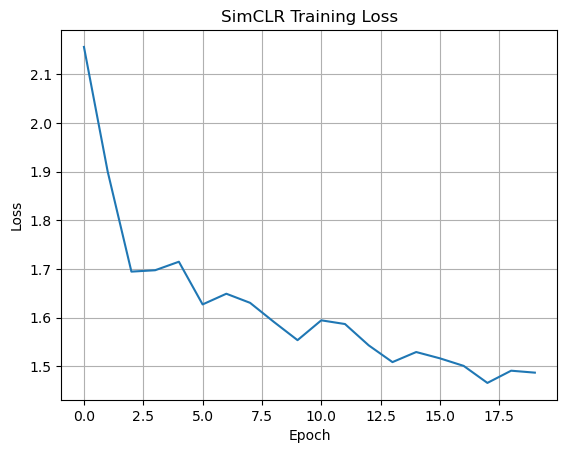

In [ ]:
import os
import glob
import numpy as np
import rasterio
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from tqdm import tqdm

# --------------------------
# Device Setup
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------
# 1. Dataset
# --------------------------
class Sentinel2Dataset(Dataset):
    def __init__(self, folder_path, crop_size=64, num_crops=1000):
        self.file_paths = glob.glob(os.path.join(folder_path, "*.tif"))
        self.crop_size = crop_size
        self.num_crops = num_crops
        self.augment = A.Compose([
            A.RandomCrop(crop_size, crop_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.GaussianBlur(p=0.3),
            ToTensorV2()
        ])

    def __len__(self):
        return self.num_crops

    def __getitem__(self, idx):
        while True:
            file_path = self.file_paths[np.random.randint(len(self.file_paths))]
            try:
                with rasterio.open(file_path) as src:
                    width, height = src.width, src.height
                    x = np.random.randint(0, width - self.crop_size)
                    y = np.random.randint(0, height - self.crop_size)

                    window = rasterio.windows.Window(x, y, self.crop_size, self.crop_size)
                    img = src.read(window=window).astype(np.float32)

                img = np.transpose(img, (1, 2, 0))
                img = (img - img.min()) / (img.max() - img.min() + 1e-6)

                aug1 = self.augment(image=img)["image"]
                aug2 = self.augment(image=img)["image"]

                return aug1, aug2
            
            except Exception as e:
                print(f"[WARNING] Skipping file {file_path} due to error: {e}")


# --------------------------
# 2. SimCLR Model
# --------------------------
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, out_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        return self.mlp(x)

class SimCLR(nn.Module):
    def __init__(self, base_encoder, projection_dim=128):
        super().__init__()
        self.encoder = base_encoder
        self.projector = ProjectionHead(self.encoder.fc.in_features, projection_dim)
        self.encoder.fc = nn.Identity()

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return z

# --------------------------
# 3. Contrastive Loss
# --------------------------
def contrastive_loss(z1, z2, temperature=0.5):
    z1 = nn.functional.normalize(z1, dim=1)
    z2 = nn.functional.normalize(z2, dim=1)
    N = z1.shape[0]
    z = torch.cat([z1, z2], dim=0)
    sim = torch.matmul(z, z.T) / temperature

    labels = torch.arange(N).to(device)
    labels = torch.cat([labels, labels], dim=0)

    mask = torch.eye(2 * N, dtype=torch.bool).to(device)
    sim.masked_fill_(mask, -1e4)

    sim_i_j = sim[:N, N:]
    sim_j_i = sim[N:, :N]

    positives = torch.cat([sim_i_j.diag(), sim_j_i.diag()], dim=0)
    negatives = sim[~mask].view(2 * N, -1)

    logits = torch.cat([positives.unsqueeze(1), negatives], dim=1)
    labels = torch.zeros(2 * N).long().to(device)

    loss = nn.CrossEntropyLoss()(logits, labels)
    return loss

# --------------------------
# 4. Training Loop
# --------------------------
def train_simclr(model, dataloader, epochs=20, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scaler = torch.cuda.amp.GradScaler()
    losses = []

    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for x1, x2 in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x1, x2 = x1.to(device, non_blocking=True), x2.to(device, non_blocking=True)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                z1 = model(x1)
                z2 = model(x2)
                loss = contrastive_loss(z1, z2)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

            # Optional: clear cache per step (helps avoid OOM in long runs)
            del x1, x2, z1, z2
            torch.cuda.empty_cache()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")
        losses.append(avg_loss)

    return losses

# --------------------------
# 5. Run Everything
# --------------------------
if __name__ == "__main__":
    folder_path = "D:/FINAL_RESEARCH_FIRST_MODEL/FINAL_060425/images"

    dataset = Sentinel2Dataset(folder_path, crop_size=64, num_crops=1000)
    
    dataloader = DataLoader(
        dataset,
        batch_size=8,  # ⬅️ Decreased from 16 to reduce memory usage
        shuffle=True,
        num_workers=0,
        pin_memory=True  # ⬅️ Helps transfer speed
    )

    resnet = models.resnet18(pretrained=False)
    resnet.conv1 = nn.Conv2d(10, 64, kernel_size=7, stride=2, padding=3, bias=False)  # For 10 bands

    model = SimCLR(resnet).to(device)

    losses = train_simclr(model, dataloader, epochs=20)

    torch.save(model.encoder.state_dict(), "simclr_encoder_1.pth")

    plt.plot(losses)
    plt.title("SimCLR Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()


In [10]:
# Load the saved encoder weights
resnet = models.resnet18(pretrained=False)
resnet.conv1 = nn.Conv2d(10, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet.fc = nn.Identity()  # Remove classification head

encoder = resnet.to(device)
encoder.load_state_dict(torch.load("simclr_encoder_1.pth"))
encoder.eval()

c:\Users\Parul\miniconda3\envs\vissl_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Parul\miniconda3\envs\vissl_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Parul\AppData\Local\Temp\ipykernel_16176\3393477333.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value f

ResNet(
  (conv1): Conv2d(10, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

Using device: cuda


c:\Users\Parul\miniconda3\envs\vissl_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Parul\miniconda3\envs\vissl_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Parul\AppData\Local\Temp\ipykernel_18828\2833216490.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value 

Found 6 TIFF files

Processing 2019.tif...


2019.tif: 100%|██████████| 103/103 [00:28<00:00,  3.66it/s]



Processing 2020.tif...


2020.tif: 100%|██████████| 103/103 [00:27<00:00,  3.80it/s]



Processing 2021.tif...


2021.tif: 100%|██████████| 103/103 [00:27<00:00,  3.81it/s]



Processing 2022.tif...


2022.tif: 100%|██████████| 103/103 [00:26<00:00,  3.89it/s]



Processing 2023.tif...


2023.tif: 100%|██████████| 103/103 [00:26<00:00,  3.95it/s]



Processing 2024.tif...


2024.tif: 100%|██████████| 103/103 [00:26<00:00,  3.88it/s]
c:\Users\Parul\miniconda3\envs\vissl_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Saved cluster labels to D:/FINAL_RESEARCH_FIRST_MODEL/results


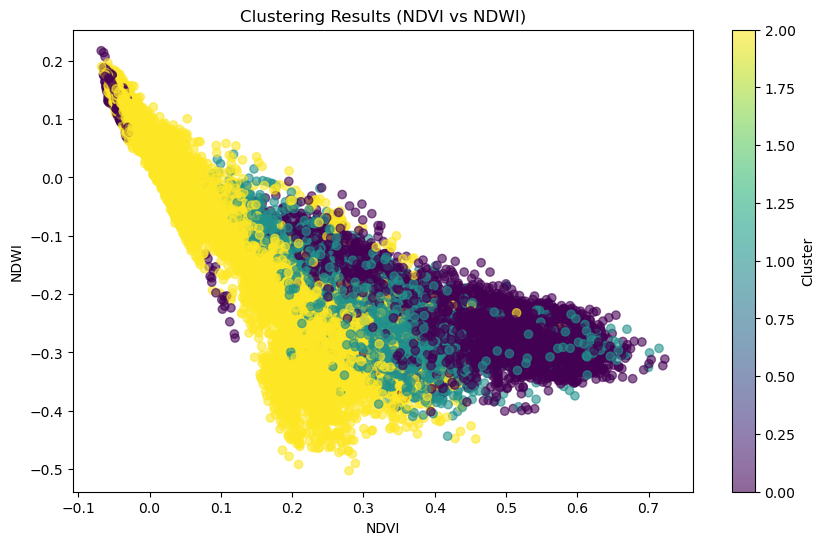

In [11]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import rasterio
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

# --------------------------
# 1. Setup & Config
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Config
BAND_INDICES = {'B2': 0, 'B3': 1, 'B4': 2, 'B8': 3}  # Adjust band order
CLUSTERS = 3  # Forest, Deforested, Other
PATCH_SIZE = 64  # Must match SimCLR training
STRIDE = 32      # Overlap for better coverage
INPUT_FOLDER = "D:/FINAL_RESEARCH_FIRST_MODEL/FINAL_060425/images"
OUTPUT_FOLDER = "D:/FINAL_RESEARCH_FIRST_MODEL/results"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# --------------------------
# 2. Load Encoder (Fixed)
# --------------------------
def load_encoder(ckpt_path):
    encoder = models.resnet18(pretrained=False)
    encoder.conv1 = nn.Conv2d(10, 64, kernel_size=7, stride=2, padding=3, bias=False)
    encoder.fc = nn.Identity()  # Remove final layer
    encoder.load_state_dict(torch.load(ckpt_path))
    return encoder.to(device).eval()

encoder = load_encoder("simclr_encoder_1.pth")

# --------------------------
# 3. Robust Data Processing
# --------------------------
def compute_indices(patch):
    """Calculate NDVI and NDWI with robust numerical checks."""
    B3 = patch[BAND_INDICES['B3']]
    B4 = patch[BAND_INDICES['B4']]
    B8 = patch[BAND_INDICES['B8']]
    
    # Initialize arrays with zeros (fallback for invalid calculations)
    ndvi = np.zeros_like(B8)
    ndwi = np.zeros_like(B3)
    
    # Mask for valid denominators
    valid_ndvi = (B8 + B4) > 1e-6
    valid_ndwi = (B3 + B8) > 1e-6
    
    # Compute only where valid
    ndvi[valid_ndvi] = (B8[valid_ndvi] - B4[valid_ndvi]) / (B8[valid_ndvi] + B4[valid_ndvi])
    ndwi[valid_ndwi] = (B3[valid_ndwi] - B8[valid_ndwi]) / (B3[valid_ndwi] + B8[valid_ndwi])
    
    return ndvi, ndwi

def process_image(image_path, stride=STRIDE):
    """Process a single image with enhanced NaN handling."""
    features = []
    try:
        with rasterio.open(image_path) as src:
            width, height = src.shape
            for y in tqdm(range(0, height - PATCH_SIZE, stride), desc=os.path.basename(image_path)):
                for x in range(0, width - PATCH_SIZE, stride):
                    window = rasterio.windows.Window(x, y, PATCH_SIZE, PATCH_SIZE)
                    patch = src.read(window=window).astype(np.float32)
                    
                    # Skip empty/invalid patches
                    if patch.size == 0 or np.isnan(patch).any() or (patch.max() - patch.min()) < 1e-6:
                        continue
                    
                    # Normalize and compute indices
                    patch_norm = (patch - patch.min()) / (patch.max() - patch.min() + 1e-6)
                    ndvi, ndwi = compute_indices(patch_norm)
                    
                    # Extract features
                    patch_tensor = torch.from_numpy(patch_norm).unsqueeze(0).float().to(device)
                    with torch.no_grad():
                        feat = encoder(patch_tensor).cpu().numpy().flatten()
                    
                    # Skip if any feature is NaN
                    if not np.isnan(feat).any() and not np.isnan(ndvi.mean()) and not np.isnan(ndwi.mean()):
                        features.append(np.concatenate([feat, [ndvi.mean(), ndwi.mean()]]))
    
    except Exception as e:
        print(f"Skipping {image_path} due to error: {e}")
    
    return np.array(features) if features else None

def cluster_and_save(features):
    if features is None or len(features) == 0:
        print("No valid features found. Check input files.")
        return
    
    # Final NaN check (should be redundant but adds safety)
    features = features[~np.isnan(features).any(axis=1)]
    if len(features) == 0:
        print("All features contained NaN after filtering.")
        return
    
    # Normalize
    scaler = StandardScaler()
    X = scaler.fit_transform(features)
    
    # Cluster
    kmeans = KMeans(n_clusters=CLUSTERS, random_state=42)
    labels = kmeans.fit_predict(X)
    
    # Save results
    np.save(os.path.join(OUTPUT_FOLDER, "cluster_labels.npy"), labels)
    print(f"Saved cluster labels to {OUTPUT_FOLDER}")
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(features[:, -2], features[:, -1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(label='Cluster')
    plt.xlabel("NDVI")
    plt.ylabel("NDWI")
    plt.title("Clustering Results (NDVI vs NDWI)")
    plt.savefig(os.path.join(OUTPUT_FOLDER, "cluster_plot.png"))
    plt.show()
# --------------------------
# 6. Run Pipeline
# --------------------------
if __name__ == "__main__":
    print(f"Found {len(glob.glob(os.path.join(INPUT_FOLDER, '*.tif')))} TIFF files")
    features = process_all_images()
    cluster_and_save(features)

In [14]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import rasterio
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

# --------------------------
# 1. Config & Paths
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_folder = "D:/FINAL_RESEARCH_FIRST_MODEL/FINAL_060425/images"
output_folder = "D:/FINAL_RESEARCH_FIRST_MODEL/results"
os.makedirs(output_folder, exist_ok=True)

# --------------------------
# 2. Define Encoder Architecture (Must Match SimCLR Training)
# --------------------------
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet18Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(10, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 10 bands
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Load ResNet18 layers (except first conv)
        resnet = models.resnet18(pretrained=False)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        return x.flatten(1)

# Load encoder
encoder = ResNet18Encoder().to(device)
encoder.load_state_dict(torch.load("simclr_encoder_1.pth"))  # Now keys match!
encoder.eval()

# --------------------------
# 3. Deforestation Detection Pipeline
# --------------------------
def detect_deforestation(image_path, stride=32):
    """Generate deforestation probability map for a single image."""
    with rasterio.open(image_path) as src:
        width, height = src.shape
        deforestation_prob = np.zeros((height, width), dtype=np.float32)
        patch_count = np.zeros((height, width), dtype=np.float32)

        for y in tqdm(range(0, height - 64, stride), desc=os.path.basename(image_path)):
            for x in range(0, width - 64, stride):
                window = rasterio.windows.Window(x, y, 64, 64)
                patch = src.read(window=window).astype(np.float32)

                # Skip empty/invalid patches
                if patch.size == 0 or np.isnan(patch).any():
                    continue

                # Normalize patch
                patch_norm = (patch - patch.min()) / (patch.max() - patch.min() + 1e-6)

                # Compute NDVI and NDWI (adjust band indices as needed)
                B3, B4, B8 = patch_norm[1], patch_norm[2], patch_norm[3]  # B3=Green, B4=Red, B8=NIR
                ndvi = (B8 - B4) / (B8 + B4 + 1e-6)
                ndwi = (B3 - B8) / (B3 + B8 + 1e-6)

                # Skip water/clouds (high NDWI)
                if np.mean(ndwi) > 0.2:
                    continue

                # Extract SimCLR features
                patch_tensor = torch.from_numpy(patch_norm).unsqueeze(0).float().to(device)
                with torch.no_grad():
                    features = encoder(patch_tensor).cpu().numpy().flatten()

                # Rule-based deforestation probability
                prob = 0.0
                if np.mean(ndvi) < 0.3:  # Low NDVI = likely deforestation
                    prob += 0.7
                if np.mean(features) < 0:  # SimCLR features (empirical threshold)
                    prob += 0.3
                prob = min(prob, 1.0)

                # Update probability map
                deforestation_prob[y:y+64, x:x+64] += prob
                patch_count[y:y+64, x:x+64] += 1

        # Normalize by patch count
        deforestation_prob /= (patch_count + 1e-6)
        return deforestation_prob

# --------------------------
# 4. Process All Images & Save Results
# --------------------------
for tiff_file in os.listdir(input_folder):
    if tiff_file.endswith(".tif"):
        print(f"\nProcessing {tiff_file}...")
        prob_map = detect_deforestation(os.path.join(input_folder, tiff_file))
        
        # Save as GeoTIFF
        with rasterio.open(os.path.join(input_folder, tiff_file)) as src:
            profile = src.profile
            profile.update(dtype=rasterio.float32, count=1)
            
            with rasterio.open(os.path.join(output_folder, f"deforestation_prob_{tiff_file}"), 'w', **profile) as dst:
                dst.write(prob_map, 1)

        # Plot heatmap
        plt.figure(figsize=(12, 8))
        plt.imshow(prob_map, cmap="RdYlGn_r", vmin=0, vmax=1)
        plt.colorbar(label="Deforestation Probability")
        plt.title(f"Deforestation Heatmap: {tiff_file}")
        plt.savefig(os.path.join(output_folder, f"heatmap_{tiff_file.replace('.tif', '.png')}"))
        plt.close()

print("Done! Results saved to:", output_folder)

C:\Users\Parul\AppData\Local\Temp\ipykernel_18828\4055302769.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load("simclr_encoder_1.pth"))


Processing 2019.tif...


2019.tif: 100%|██████████| 103/103 [00:18<00:00,  5.47it/s]



Processing 2020.tif...


2020.tif: 100%|██████████| 103/103 [00:18<00:00,  5.46it/s]



Processing 2021.tif...


2021.tif: 100%|██████████| 103/103 [00:18<00:00,  5.47it/s]



Processing 2022.tif...


2022.tif: 100%|██████████| 103/103 [00:18<00:00,  5.43it/s]



Processing 2023.tif...


2023.tif: 100%|██████████| 103/103 [00:19<00:00,  5.22it/s]



Processing 2024.tif...


2024.tif: 100%|██████████| 103/103 [00:18<00:00,  5.44it/s]


Done! Results saved to: D:/FINAL_RESEARCH_FIRST_MODEL/results


Loaded: D:/FINAL_RESEARCH_FIRST_MODEL/results\deforestation_prob_2019.tif
Loaded: D:/FINAL_RESEARCH_FIRST_MODEL/results\deforestation_prob_2020.tif
Loaded: D:/FINAL_RESEARCH_FIRST_MODEL/results\deforestation_prob_2021.tif
Loaded: D:/FINAL_RESEARCH_FIRST_MODEL/results\deforestation_prob_2022.tif
Loaded: D:/FINAL_RESEARCH_FIRST_MODEL/results\deforestation_prob_2023.tif
Loaded: D:/FINAL_RESEARCH_FIRST_MODEL/results\deforestation_prob_2024.tif
Saved change map to: D:/FINAL_RESEARCH_FIRST_MODEL/change_maps\deforestation_change_2019-2024.png


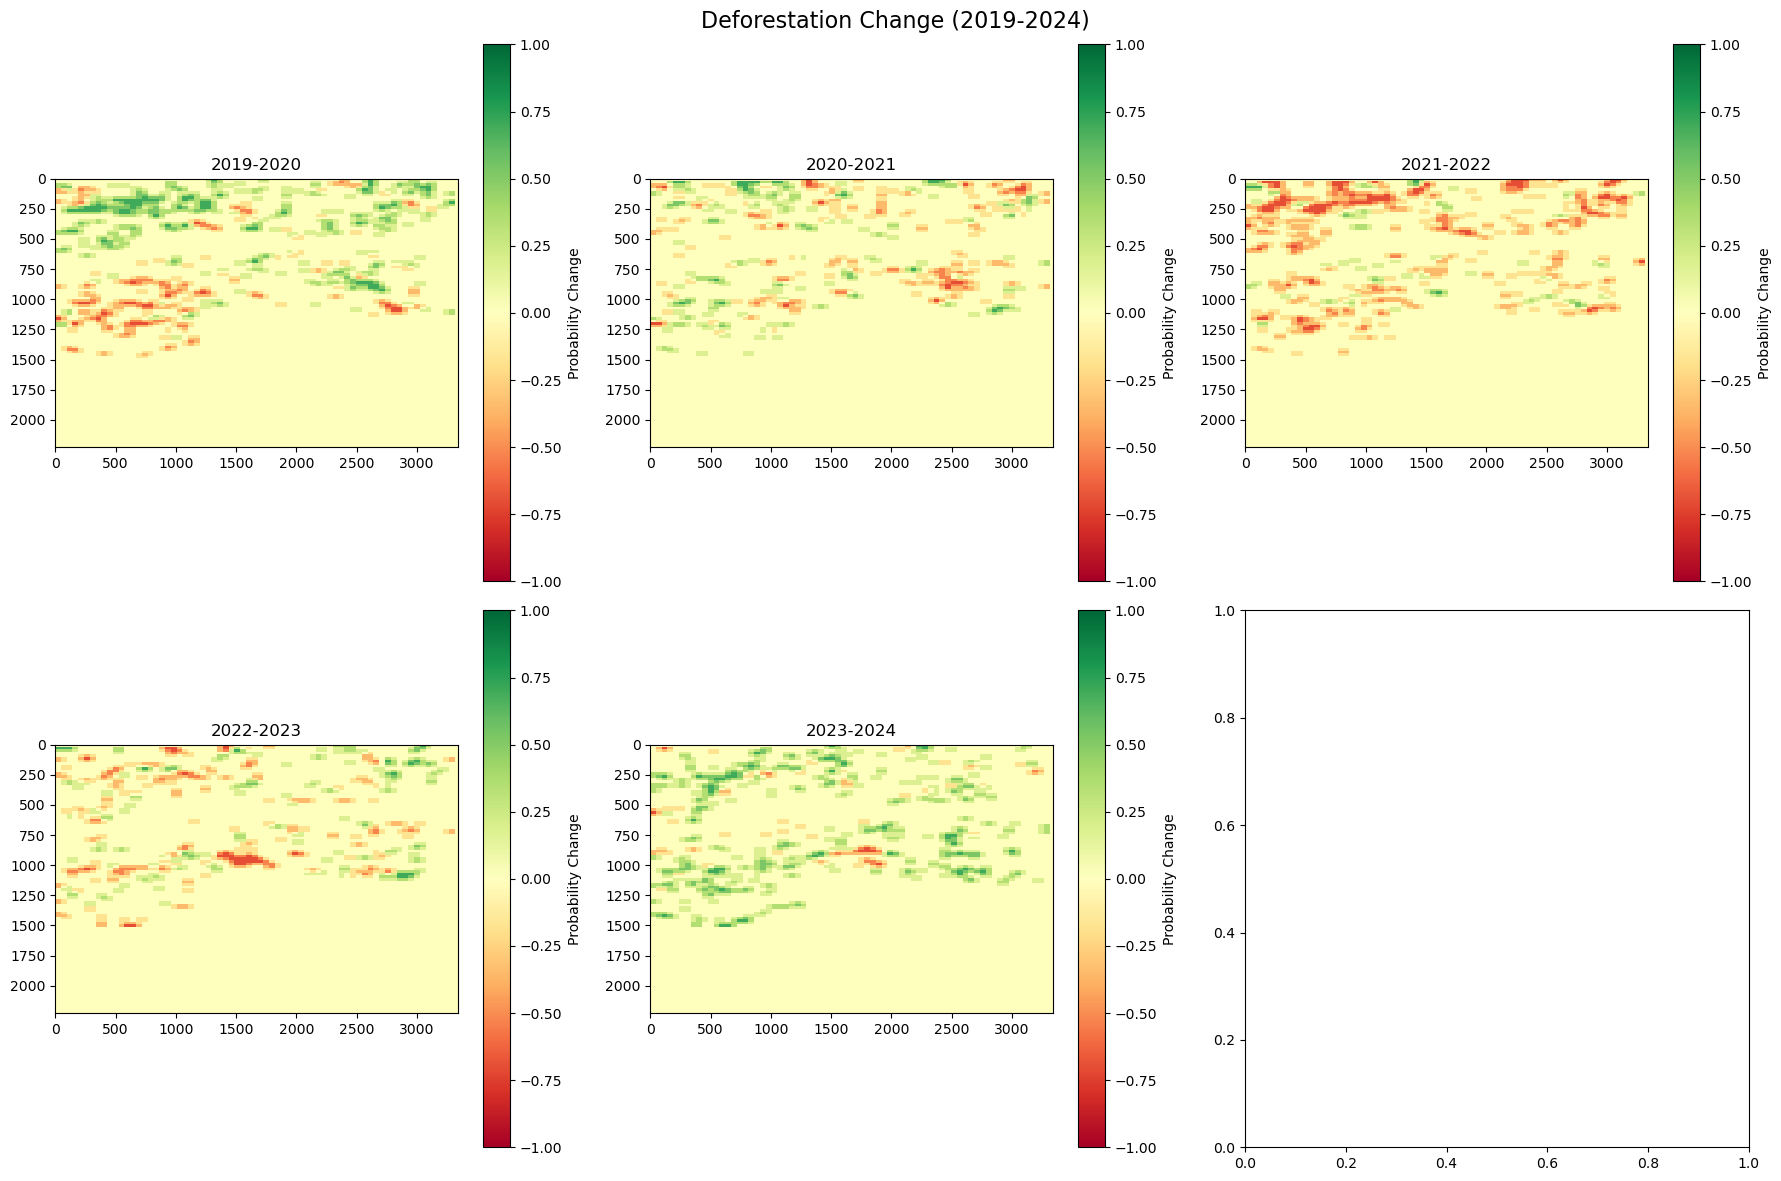

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os

# 1. Define complete paths
input_folder = "D:/FINAL_RESEARCH_FIRST_MODEL/results"  # Replace with your actual folder path
output_folder = "D:/FINAL_RESEARCH_FIRST_MODEL/change_maps"
os.makedirs(output_folder, exist_ok=True)  # Create output folder if it doesn't exist

# 2. Load deforestation probability maps (2019-2024)
years = [2019, 2020, 2021, 2022, 2023, 2024]
prob_maps = {}
for year in years:
    file_path = os.path.join(input_folder, f"deforestation_prob_{year}.tif")  # Full path
    try:
        with rasterio.open(file_path) as src:
            prob_maps[year] = src.read(1)
        print(f"Loaded: {file_path}")
    except FileNotFoundError:
        print(f"⚠️ File not found: {file_path}. Skipping...")
        continue

# 3. Compute change maps (yearly differences)
change_maps = {}
for i in range(len(years)-1):
    if years[i] in prob_maps and years[i+1] in prob_maps:  # Check if both years exist
        change_maps[f"{years[i]}-{years[i+1]}"] = prob_maps[years[i+1]] - prob_maps[years[i]]

# 4. Plot changes
if change_maps:  # Only plot if change_maps is not empty
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle("Deforestation Change (2019-2024)", fontsize=16)
    for idx, (period, change) in enumerate(change_maps.items()):
        ax = axes.flatten()[idx]
        im = ax.imshow(change, cmap="RdYlGn", vmin=-1, vmax=1, interpolation='nearest')
        ax.set_title(period)
        fig.colorbar(im, ax=ax, label="Probability Change")
    plt.tight_layout()
    
    # Save and show
    output_path = os.path.join(output_folder, "deforestation_change_2019-2024.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Saved change map to: {output_path}")
    plt.show()
else:
    print("❌ No valid data to plot. Check input files.")

Loaded: D:/FINAL_RESEARCH_FIRST_MODEL/results\deforestation_prob_2019.tif
Loaded: D:/FINAL_RESEARCH_FIRST_MODEL/results\deforestation_prob_2024.tif
Saved to: D:/FINAL_RESEARCH_FIRST_MODEL/change_maps\deforestation_change_2019_2024.png


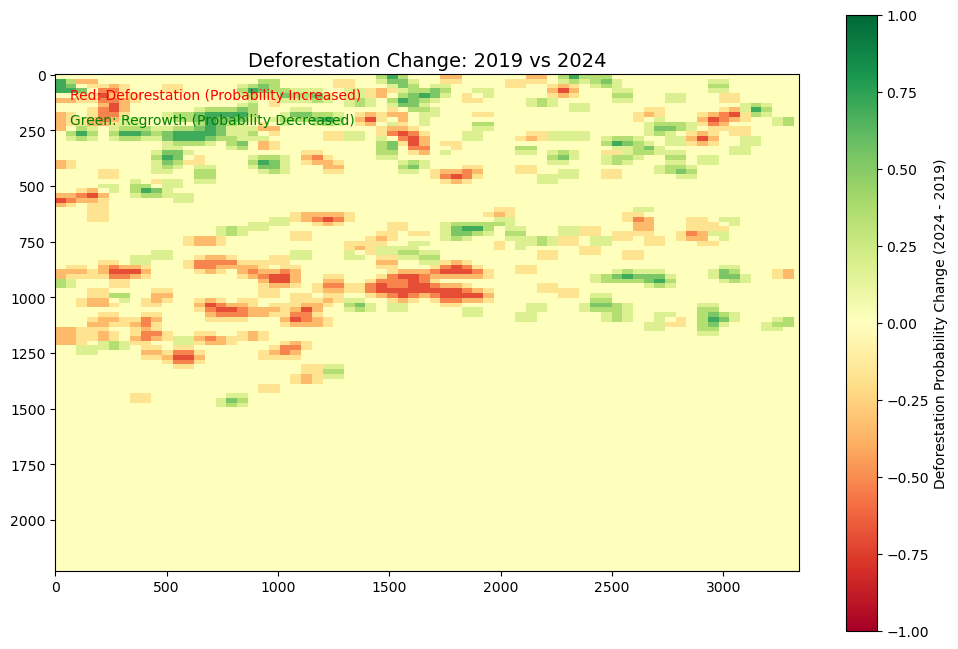

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os

# 1. Define paths
input_folder = "D:/FINAL_RESEARCH_FIRST_MODEL/results"  # Replace with your folder
output_folder = "D:/FINAL_RESEARCH_FIRST_MODEL/change_maps"
os.makedirs(output_folder, exist_ok=True)

# 2. Load 2019 and 2024 data
years = [2019, 2024]
prob_maps = {}

for year in years:
    file_path = os.path.join(input_folder, f"deforestation_prob_{year}.tif")
    try:
        with rasterio.open(file_path) as src:
            prob_maps[year] = src.read(1)
            print(f"Loaded: {file_path}")
    except FileNotFoundError:
        print(f"⚠️ File not found: {file_path}")
        exit()

# 3. Compute 2019-2024 change
change = prob_maps[2024] - prob_maps[2019]

# 4. Plot with intuitive colormap
plt.figure(figsize=(12, 8))
plt.imshow(change, 
           cmap="RdYlGn",  # Red (loss), Yellow (no change), Green (gain)
           vmin=-1, 
           vmax=1,
           interpolation='nearest')

plt.colorbar(label="Deforestation Probability Change (2024 - 2019)")
plt.title("Deforestation Change: 2019 vs 2024", fontsize=14)

# Add threshold-based annotations
plt.annotate("Red: Deforestation (Probability Increased)",
             xy=(0.02, 0.95), xycoords='axes fraction',
             color='red', fontsize=10)
plt.annotate("Green: Regrowth (Probability Decreased)",
             xy=(0.02, 0.90), xycoords='axes fraction',
             color='green', fontsize=10)

# Save and show
output_path = os.path.join(output_folder, "deforestation_change_2019_2024.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Saved to: {output_path}")
plt.show()


Forecasting future deforestation...


Forecasting rows: 100%|██████████| 2228/2228 [31:22<00:00,  1.18it/s]  



Visualizing 2025 forecast...


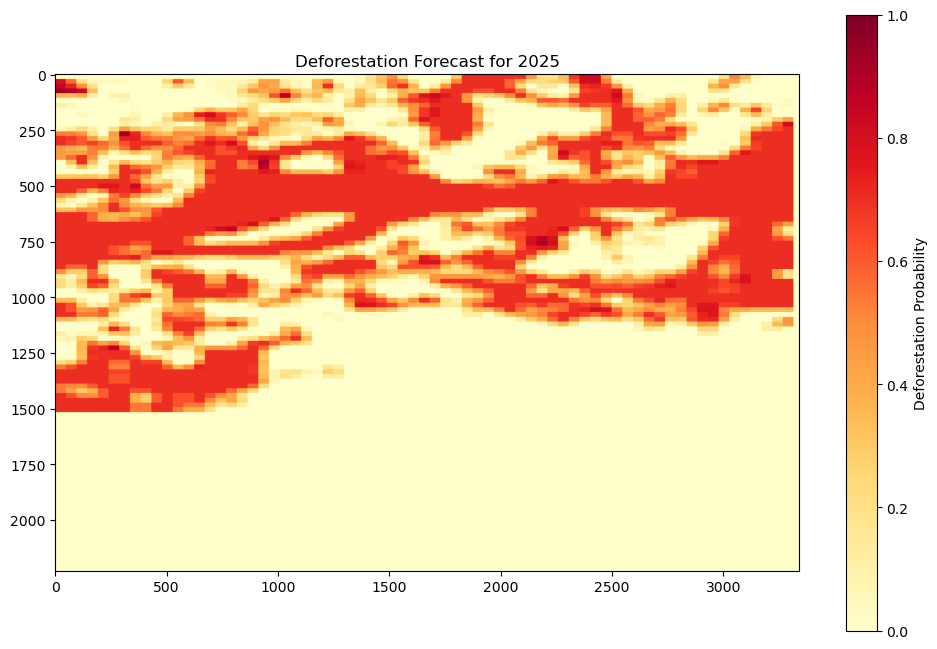


Visualizing 2026 forecast...


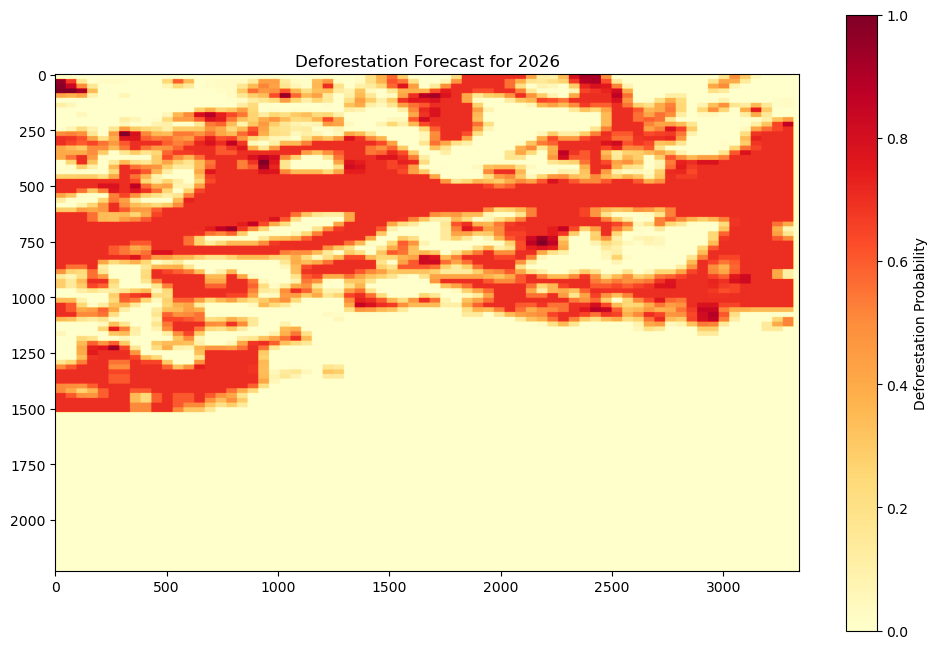


Visualizing 2027 forecast...


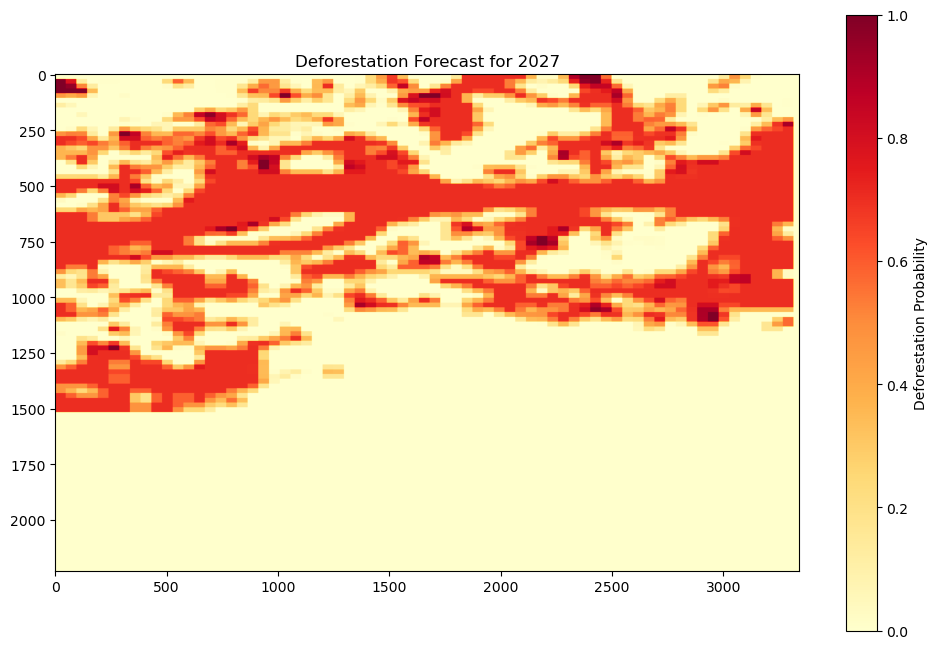


Visualizing 2028 forecast...


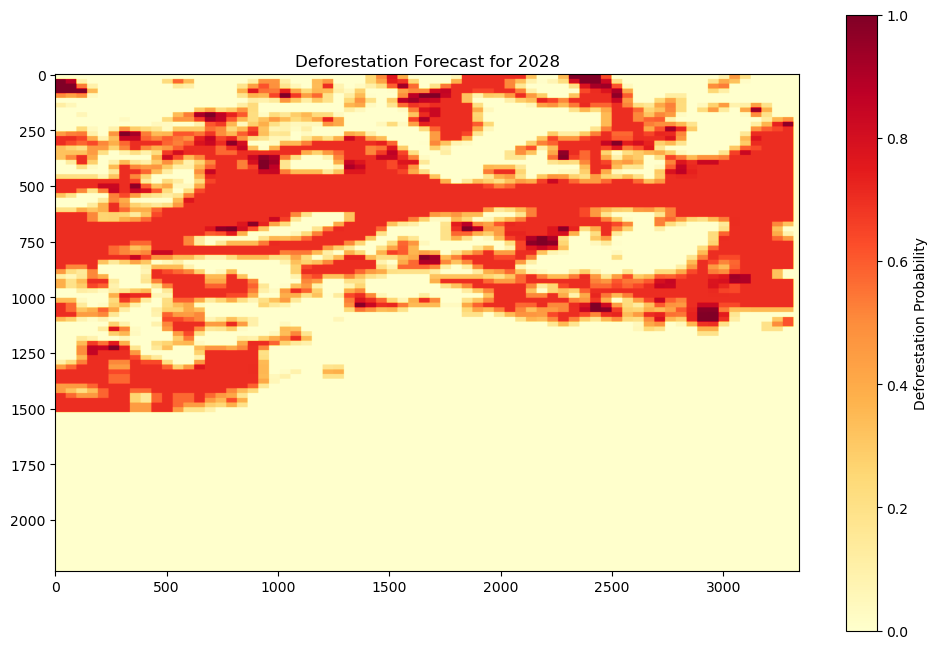


Visualizing 2029 forecast...


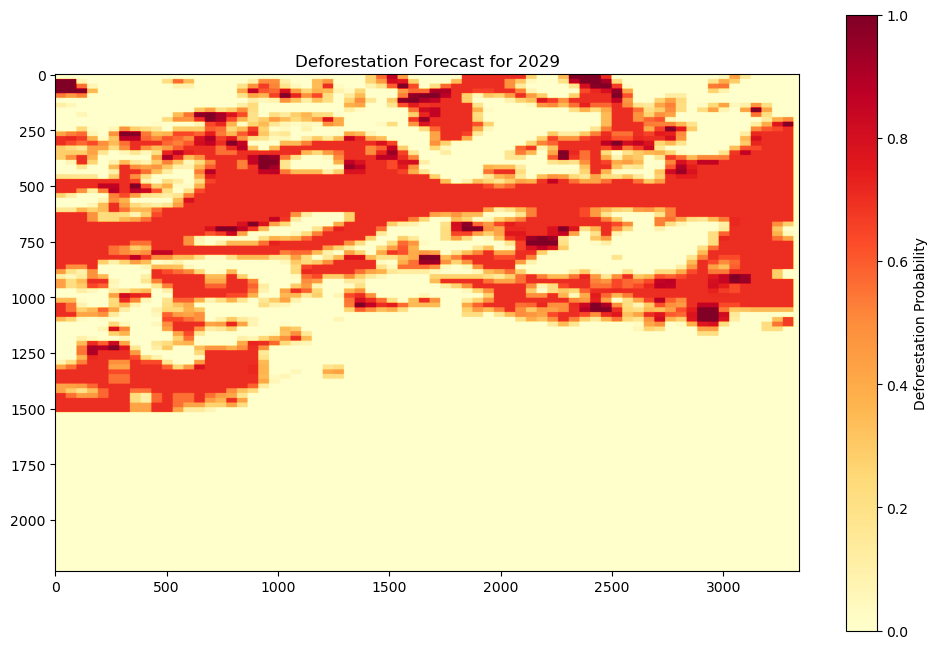


Visualizing 2030 forecast...


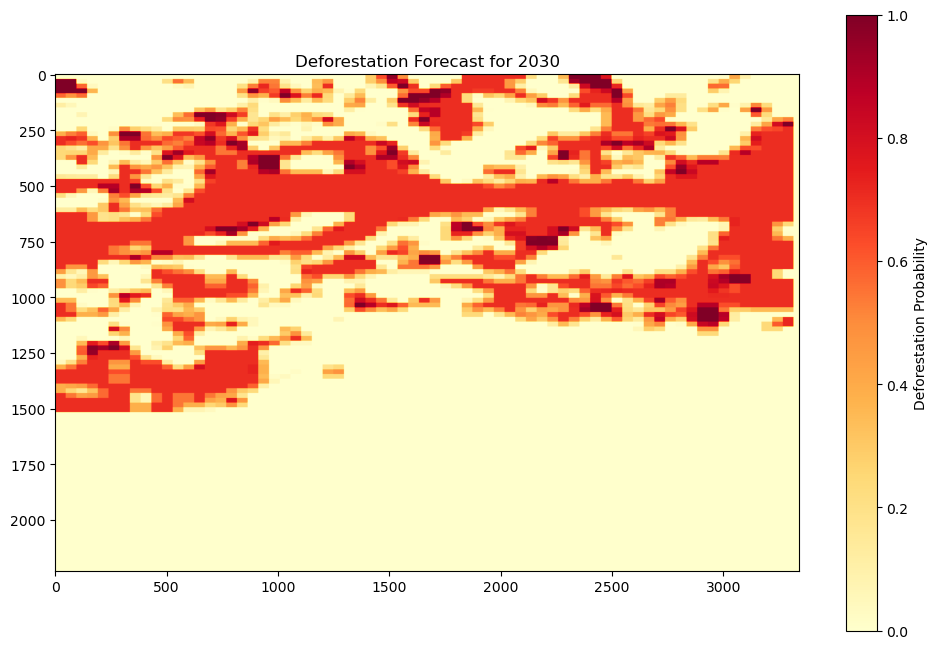


All results saved to: D:/FINAL_RESEARCH_FIRST_MODEL/forecasts


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

# --------------------------
# 1. Configuration
# --------------------------
input_folder = "D:/FINAL_RESEARCH_FIRST_MODEL/results"  # Where your probability maps are stored
output_folder = "D:/FINAL_RESEARCH_FIRST_MODEL/forecasts"
os.makedirs(output_folder, exist_ok=True)

# --------------------------
# 2. Forecasting (2025-2030)
# --------------------------
def forecast_future(years_to_predict=[2025, 2026, 2027, 2028, 2029, 2030]):
    # Load all available yearly data
    available_years = [2019, 2020, 2021, 2022, 2023, 2024]
    prob_maps = {}
    
    for year in available_years:
        try:
            with rasterio.open(os.path.join(input_folder, f"deforestation_prob_{year}.tif")) as src:
                prob_maps[year] = src.read(1)
        except FileNotFoundError:
            print(f"⚠️ Warning: Missing data for {year}")
            continue

    if len(prob_maps) < 3:
        raise ValueError("Need at least 3 years of data for forecasting")

    # Prepare time axis
    train_years = np.array(list(prob_maps.keys())).reshape(-1, 1)
    future_years = np.array(years_to_predict).reshape(-1, 1)

    # Initialize forecast storage
    forecasts = {year: np.zeros_like(list(prob_maps.values())[0]) for year in years_to_predict}

    # Pixel-wise forecasting
    rows, cols = list(prob_maps.values())[0].shape
    for i in tqdm(range(rows), desc="Forecasting rows"):
        for j in range(cols):
            # Get pixel time-series
            y = np.array([prob_maps[year][i,j] for year in prob_maps.keys()])
            
            # Skip if no variation
            if np.all(y == y[0]):
                for year in years_to_predict:
                    forecasts[year][i,j] = y[0]
                continue
                
            # Fit linear model
            model = LinearRegression()
            model.fit(train_years, y)
            
            # Predict future
            preds = model.predict(future_years)
            for idx, year in enumerate(years_to_predict):
                forecasts[year][i,j] = np.clip(preds[idx], 0, 1)  # Keep in 0-1 range

    # Save forecasts
    for year, data in forecasts.items():
        with rasterio.open(os.path.join(output_folder, f"forecast_{year}.tif"), 'w', **meta) as dst:
            dst.write(data, 1)
    
    return forecasts

# --------------------------
# 3. Visualization
# --------------------------
def plot_forecast(forecast_data, year):
    plt.figure(figsize=(12, 8))
    im = plt.imshow(forecast_data, cmap="YlOrRd", vmin=0, vmax=1)
    plt.colorbar(im, label="Deforestation Probability")
    plt.title(f"Deforestation Forecast for {year}")
    plt.savefig(os.path.join(output_folder, f"forecast_{year}_vis.png"), dpi=300)
    plt.show()

# --------------------------
# 4. Run Pipeline
# --------------------------
if __name__ == "__main__":
    
    # Step 1: Forecasting
    print("\nForecasting future deforestation...")
    forecasts = forecast_future()
    
    # Step 2: Visualize forecasts
    for year, data in forecasts.items():
        print(f"\nVisualizing {year} forecast...")
        plot_forecast(data, year)
    
    print(f"\nAll results saved to: {output_folder}")

In [22]:
import numpy as np
from sklearn.cluster import KMeans

# Assume you have features from SimCLR + NDVI/NDWI concatenated
# features.shape = [N_samples, feature_dim + 2] (2 for NDVI/NDWI)

# Perform clustering (3 clusters: deforested, forested, non-forested)
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# Count pixels per cluster
cluster_counts = np.bincount(cluster_labels)
print(f"Cluster counts: {cluster_counts}")

# Assign semantic labels based on NDVI/NDWI
cluster_ndvi_means = [np.mean(features[cluster_labels == i, -2]) for i in range(3)]
cluster_ndwi_means = [np.mean(features[cluster_labels == i, -1]) for i in range(3)]

# Label clusters (empirical rules)
cluster_names = []
for i in range(3):
    if cluster_ndvi_means[i] < 0.3 and cluster_ndwi_means[i] < 0.1:
        cluster_names.append("Deforested")
    elif cluster_ndvi_means[i] > 0.6 and cluster_ndwi_means[i] < 0.2:
        cluster_names.append("Forested")
    else:
        cluster_names.append("Non-Forested (Other)")

print("Cluster assignments:")
for i in range(3):
    print(f"Cluster {i}: {cluster_names[i]} (NDVI={cluster_ndvi_means[i]:.2f}, NDWI={cluster_ndwi_means[i]:.2f})")

c:\Users\Parul\miniconda3\envs\vissl_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster counts: [ 9686 11959  6453]
Cluster assignments:
Cluster 0: Non-Forested (Other) (NDVI=0.44, NDWI=-0.25)
Cluster 1: Deforested (NDVI=0.23, NDWI=-0.16)
Cluster 2: Deforested (NDVI=0.23, NDWI=-0.25)


In [3]:
import os
import numpy as np
import rasterio
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Config
input_folder = "D:/FINAL_RESEARCH_FIRST_MODEL/results"
years = list(range(2019, 2024))  # Training years
test_year = 2024

# Load data
def load_probability_maps(years, input_folder):
    maps = {}
    for year in years:
        try:
            with rasterio.open(os.path.join(input_folder, f"deforestation_prob_{year}.tif")) as src:
                maps[year] = src.read(1)
        except:
            print(f"Missing year: {year}")
    return maps

def forecast_and_evaluate(train_maps, test_map, model_type="linear"):
    train_years = np.array(sorted(train_maps.keys())).reshape(-1, 1)
    test_year = np.array([[2024]])

    shape = list(train_maps.values())[0].shape
    pred_map = np.zeros(shape)
    true_map = test_map

    # Flatten time series for each pixel
    for i in tqdm(range(shape[0]), desc="Forecasting"):
        for j in range(shape[1]):
            y_train = np.array([train_maps[year][i, j] for year in train_maps.keys()])
            
            if np.all(y_train == y_train[0]):
                pred_map[i, j] = y_train[0]
                continue
            
            if model_type == "linear":
                model = LinearRegression()
            elif model_type == "rf":
                model = RandomForestRegressor(n_estimators=50)
            else:
                raise ValueError("Unsupported model")

            model.fit(train_years, y_train)
            pred_map[i, j] = np.clip(model.predict(test_year)[0], 0, 1)

    return pred_map, true_map

# Load data
train_maps = load_probability_maps(years, input_folder)
with rasterio.open(os.path.join(input_folder, f"deforestation_prob_{test_year}.tif")) as src:
    test_map = src.read(1)
    meta = src.meta.copy()

# Forecast with both models
results = {}
for model_type in ["linear", "rf"]:
    pred, truth = forecast_and_evaluate(train_maps, test_map, model_type)
    
    # Evaluate
    mae = mean_absolute_error(truth.flatten(), pred.flatten())
    rmse = np.sqrt(mean_squared_error(truth.flatten(), pred.flatten()))
    r2 = r2_score(truth.flatten(), pred.flatten())
    
    print(f"\n📊 {model_type.upper()} MODEL:")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")
    
    results[model_type] = pred
    
    # Save prediction heatmap
    plt.figure(figsize=(10, 6))
    plt.imshow(pred, cmap="YlOrRd", vmin=0, vmax=1)
    plt.title(f"{model_type.upper()} Forecast for 2024")
    plt.colorbar(label="Deforestation Probability")
    plt.savefig(f"{model_type}_forecast_2024.png", dpi=300)
    plt.close()

    # 🔄 Save prediction as GeoTIFF
    out_path = os.path.join(input_folder, f"{model_type}_forecast_2024.tif")
    with rasterio.open(out_path, 'w', **meta) as dst:
        dst.write(pred.astype(rasterio.float32), 1)

Forecasting: 100%|██████████| 2228/2228 [29:26<00:00,  1.26it/s] 



📊 LINEAR MODEL:
MAE:  0.0627
RMSE: 0.1444
R²:   0.7742


Forecasting:   2%|▏         | 34/2228 [40:28<43:31:30, 71.42s/it] 


KeyboardInterrupt: 

In [10]:
import os
import numpy as np
import rasterio
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Config
input_folder = "D:/FINAL_RESEARCH_FIRST_MODEL/results"
years = list(range(2019, 2024))  # Training years
test_year = 2024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
def load_probability_maps(years, input_folder):
    maps = {}
    for year in years:
        try:
            with rasterio.open(os.path.join(input_folder, f"deforestation_prob_{year}.tif")) as src:
                maps[year] = src.read(1)
        except:
            print(f"Missing year: {year}")
    return maps

# Vectorized Linear Regression (no training loop)
def fast_linear_forecast(train_maps, test_map, test_year):
    train_years = torch.tensor(sorted(train_maps.keys()), dtype=torch.float32).to(device)
    test_year_tensor = torch.tensor([test_year], dtype=torch.float32).to(device)

    # Stack maps: shape [T, H, W]
    stacked = torch.stack([torch.tensor(train_maps[y], dtype=torch.float32) for y in train_maps], dim=0).to(device)
    T, H, W = stacked.shape
    X = train_years.view(T, 1, 1).expand(-1, H, W)
    Y = stacked

    x_mean = X.mean(dim=0)
    y_mean = Y.mean(dim=0)

    cov_xy = ((X - x_mean) * (Y - y_mean)).sum(dim=0)
    var_x = ((X - x_mean) ** 2).sum(dim=0)
    slope = cov_xy / (var_x + 1e-8)
    intercept = y_mean - slope * x_mean

    pred = slope * test_year_tensor + intercept
    pred = pred.clamp(0, 1).cpu().numpy()
    return pred, test_map

# Neural Net Regressor
class SimpleRegressor(nn.Module):
    def __init__(self, input_dim):
        super(SimpleRegressor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.fc(x)

def neural_forecast(train_maps, test_map, test_year):
    T = len(train_maps)
    H, W = list(train_maps.values())[0].shape
    stacked = np.stack([train_maps[y] for y in sorted(train_maps.keys())], axis=0)  # [T, H, W]
    flat_train = stacked.reshape(T, -1).T  # [N, T]
    flat_labels = test_map.reshape(-1)  # [N]

    # Torch tensors
    X = torch.tensor(flat_train, dtype=torch.float32).to(device)
    y = torch.tensor(flat_labels, dtype=torch.float32).unsqueeze(1).to(device)

    model = SimpleRegressor(input_dim=T).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X).squeeze(1)
        preds = torch.clamp(preds, 0, 1).cpu().numpy()

    pred_map = preds.reshape(H, W)
    return pred_map, test_map

# Load data
train_maps = load_probability_maps(years, input_folder)
with rasterio.open(os.path.join(input_folder, f"deforestation_prob_{test_year}.tif")) as src:
    test_map = src.read(1)
    meta = src.meta.copy()

# Evaluate models
results = {}
for model_name, model_func in {
    "linear": fast_linear_forecast,
    "neural": neural_forecast
}.items():
    print(f"\n🔍 Running {model_name.upper()} model...")
    pred, truth = model_func(train_maps, test_map, test_year)

    # Metrics
    mae = mean_absolute_error(truth.flatten(), pred.flatten())
    rmse = np.sqrt(mean_squared_error(truth.flatten(), pred.flatten()))
    r2 = r2_score(truth.flatten(), pred.flatten())

    print(f"\n📊 {model_name.upper()} MODEL:")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    # Save results
    results[model_name] = pred

    # Heatmap
    plt.figure(figsize=(10, 6))
    plt.imshow(pred, cmap="YlOrRd", vmin=0, vmax=1)
    plt.title(f"{model_name.upper()} Forecast for {test_year}")
    plt.colorbar(label="Deforestation Probability")
    plt.savefig(f"{model_name}_forecast_{test_year}.png", dpi=300)
    plt.close()

    # GeoTIFF Save
    out_path = os.path.join(input_folder, f"{model_name}_forecast_{test_year}.tif")
    with rasterio.open(out_path, 'w', **meta) as dst:
        dst.write(pred.astype(rasterio.float32), 1)



🔍 Running LINEAR model...

📊 LINEAR MODEL:
MAE:  0.0627
RMSE: 0.1444
R²:   0.7741

🔍 Running NEURAL model...

📊 NEURAL MODEL:
MAE:  0.0502
RMSE: 0.1058
R²:   0.8787


📊 Evaluation Metrics (Threshold = 0.5)
Precision: 0.9498
Recall:    0.7077
F1 Score:  0.8111
Accuracy:  0.8955

Confusion Matrix:
[[4994836   88272]
 [ 689952 1670688]]

Classification Report:
                precision    recall  f1-score   support

Non-Deforested       0.88      0.98      0.93   5083108
    Deforested       0.95      0.71      0.81   2360640

      accuracy                           0.90   7443748
     macro avg       0.91      0.85      0.87   7443748
  weighted avg       0.90      0.90      0.89   7443748



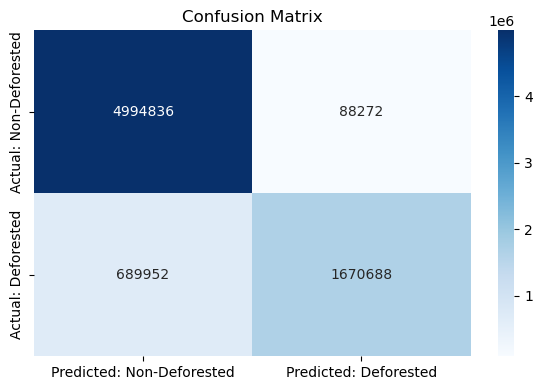

In [12]:
import numpy as np
import rasterio
import os
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# CONFIGURATION
# ------------------------------
results_folder = "D:/FINAL_RESEARCH_FIRST_MODEL/results"
forecast_file = "linear_forecast_2024.tif"     # Or 'linear_forecast_2024.tif'
actual_file = "deforestation_prob_2024.tif"
threshold = 0.5  # Threshold to classify as deforested

# ------------------------------
# LOAD PREDICTION & ACTUAL MAPS
# ------------------------------
def load_raster(path):
    with rasterio.open(path) as src:
        data = src.read(1)
    return data

y_pred_prob = load_raster(os.path.join(results_folder, forecast_file))
y_true_prob = load_raster(os.path.join(results_folder, actual_file))

# ------------------------------
# BINARIZE: Convert to 0 or 1
# ------------------------------
y_pred_bin = (y_pred_prob > threshold).astype(int)
y_true_bin = (y_true_prob > threshold).astype(int)

# Flatten to 1D arrays for sklearn
y_pred_flat = y_pred_bin.flatten()
y_true_flat = y_true_bin.flatten()

# Optional: Remove invalid/masked pixels (if any)
valid_mask = ~np.isnan(y_true_flat)
y_true_flat = y_true_flat[valid_mask]
y_pred_flat = y_pred_flat[valid_mask]

# ------------------------------
# EVALUATION METRICS
# ------------------------------
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)
accuracy = accuracy_score(y_true_flat, y_pred_flat)
conf_mat = confusion_matrix(y_true_flat, y_pred_flat)

# ------------------------------
# PRINT RESULTS
# ------------------------------
print("📊 Evaluation Metrics (Threshold = 0.5)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_mat)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_true_flat, y_pred_flat, target_names=["Non-Deforested", "Deforested"]))

# ------------------------------
# OPTIONAL: Plot Confusion Matrix
# ------------------------------
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted: Non-Deforested", "Predicted: Deforested"],
            yticklabels=["Actual: Non-Deforested", "Actual: Deforested"])
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "confusion_matrix_2024.png"), dpi=300)
plt.show()


In [19]:
import rasterio
import numpy as np

# Config
tif_path = "D:/FINAL_RESEARCH_FIRST_MODEL/forecasts/forecast_2030.tif"  # Replace with your path
threshold = 0.7  # You can change this value depending on your risk definition

# Load the raster
with rasterio.open(tif_path) as src:
    prob_map = src.read(1)
    pixel_area = abs(src.transform[0] * src.transform[4])  # Calculate area if needed

# Compute high-risk area percentage
total_pixels = prob_map.size
high_risk_pixels = np.sum(prob_map > threshold)
high_risk_percent = (high_risk_pixels / total_pixels) * 100

print(f"🌲 High-risk deforestation area (> {threshold} prob): {high_risk_percent:.2f}%")


🌲 High-risk deforestation area (> 0.7 prob): 4.17%


In [23]:
import os
import numpy as np
import rasterio

# Config
input_folder = "D:/FINAL_RESEARCH_FIRST_MODEL/forecasts"  # Folder with forecast .tif files
model_type = "rf"  # or "linear", depending on your saved file names
years = range(2025, 2031)
threshold = 0.7  # Deforestation risk threshold

# Loop through years
for year in years:
    tif_path = os.path.join(input_folder, f"forecast_{year}.tif")
    
    with rasterio.open(tif_path) as src:
        prob_map = src.read(1)
        pixel_area = abs(src.transform[0] * src.transform[4])  # pixel area in m²

    total_pixels = prob_map.size
    high_risk_pixels = np.sum(prob_map > threshold)
    
    high_risk_percent = (high_risk_pixels / total_pixels) * 100

    print(f"📅 Year {year}")
    print(f"   🌲 High-risk Area (%): {high_risk_percent:.2f}%")


📅 Year 2025
   🌲 High-risk Area (%): 1.61%
📅 Year 2026
   🌲 High-risk Area (%): 2.06%
📅 Year 2027
   🌲 High-risk Area (%): 2.33%
📅 Year 2028
   🌲 High-risk Area (%): 3.60%
📅 Year 2029
   🌲 High-risk Area (%): 3.76%
📅 Year 2030
   🌲 High-risk Area (%): 4.17%
